In [1]:
#used mainly in the data interpretation, analysis, and visulaization
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#used in the training 
import torch
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm
from torch.utils.data.dataset import Dataset #used in transformation
from torch.utils.data import DataLoader #creating a dataloader
from torch.optim.lr_scheduler import StepLR#Training Scheduler 
import time # early exit mechanic if validation doesn't improve.


#Dataset splitting

from sklearn.model_selection import train_test_split

#Cluster Checking
from sklearn.cluster import KMeans







In [2]:
movies = pd.read_csv('C:/Users/yohan/OneDrive/Desktop/archive/movies.csv')
ratings = pd.read_csv('C:/Users/yohan/OneDrive/Desktop/archive/ratings.csv')
tags = pd.read_csv('C:/Users/yohan/OneDrive/Desktop/archive/tags.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [9]:
crating = ratings['rating']
cgenre = movies['genres']
dfratings = pd.DataFrame(ratings)
dfmovies = pd.DataFrame(movies)
dftags = pd.DataFrame(tags)

In [134]:
# Preprocessing of the data

# user_ids = dfratings['userId'].values
# movie_ids = dfratings['movieId'].values
# ratings = dfratings['rating'].values

# Normalize user and movie IDs (optional for embeddings)
# scaler = StandardScaler()
# normalized_user_ids = scaler.fit_transform(user_ids.reshape(-1, 1))
# normalized_movie_ids = scaler.fit_transform(movie_ids.reshape(-1, 1))


# dfratings['userId'] = normalized_user_ids
# dfratings['movieId'] = normalized_movie_ids

In [11]:
movie_names = dfmovies.set_index('movieId')['title'].to_dict()
n_users = len(dfratings.userId.unique())
n_movies = len(dfratings.movieId.unique())
print("The number of unique users is: ",n_users)
print("The number of unique users is: ",n_movies)
print("The total elements is: ",n_users * n_movies)

The number of unique users is:  610
The number of unique users is:  9724
The total elements is:  5931640


In [13]:
# simple data analyisis
print(np.mean(crating))
print(np.median(crating))
print(crating.mode()[0])
print(np.std(crating,ddof=1))

3.501556983616962
3.5
4.0
1.0425292390605359


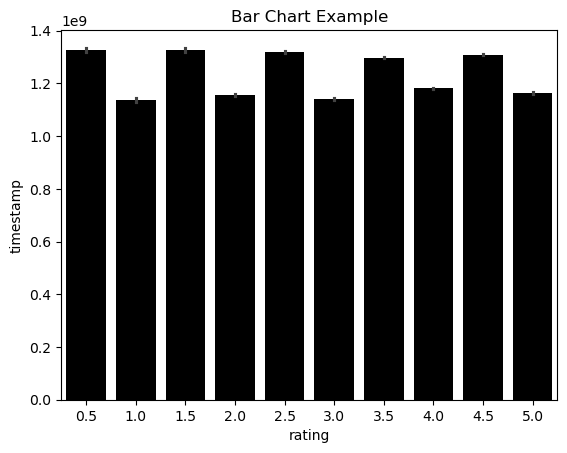

In [15]:
# simple data representation 
# Bar Chart
sns.barplot(data=dfratings, x='rating', y='timestamp', color='black')  
plt.title('Bar Chart Example')
plt.show()

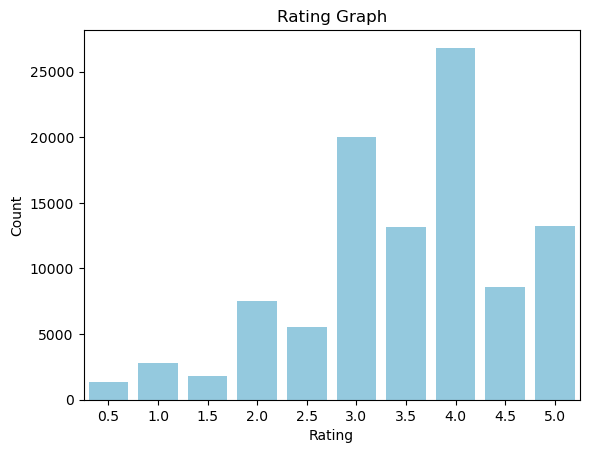

In [17]:
#countplot of the ratings
sns.countplot(data = dfratings, x = 'rating', color = 'skyblue')
plt.title('Rating Graph')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [19]:
#world cloud for the movie genre 

text = " ".join(dfmovies['genres'].dropna())
wordcloud = WordCloud(width = 7000, height = 5000, background_color= 'white').generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

KeyboardInterrupt: 

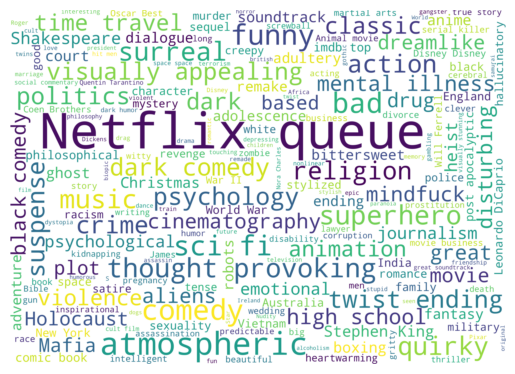

In [21]:
# word cloud for tags 
text = " ".join(dftags['tag'].dropna())
wordcloud = WordCloud(width = 7000, height = 5000, background_color = 'white').generate(text)
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [73]:
# Modeling and the real hash work
# We're going to be using Matrix Factorization and Collaborative System to train
# K Means Clustering is used to test

class MartixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_movies, n_factors = 20):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.movie_factors = torch.nn.Embedding(n_movies, n_factors)
        
        self.user_factors.weight.data.uniform_(0,0.05)
        self.movie_factors.weight.data.uniform_(0,0.05)

    def forward(self, data):
        users, movies = data[:,0], data[:,1]
        return (self.user_factors(users)*self.movie_factors(movies)).sum(1)

    def predict(self, user, movies):
        return self.forward(user,movies)



In [75]:

class Loader(Dataset):
    def __init__(self,data):
        self.ratings = data.copy()
        
     
        users = dfratings.userId.unique()
        movies = dfratings.movieId.unique()
        
       
        

        self.userid2idx = {o:i for i,o in enumerate(users)}
        self.movieid2idx = {o:i for i,o in enumerate(movies)}
        

        self.idx2userid = {i:o for o,i in self.userid2idx.items()}
        self.idx2movieid = {i:o for o,i in self.movieid2idx.items()}
        

        self.ratings.movieId = dfratings.movieId.apply(lambda x: self.movieid2idx[x])
        self.ratings.userId = dfratings.userId.apply(lambda x: self.userid2idx[x])
        
        
        self.x = self.ratings.drop(['rating', 'timestamp'], axis=1).values
        self.y = self.ratings['rating'].values
        self.x, self.y = torch.tensor(self.x), torch.tensor(self.y) 

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.ratings)

In [3]:
# redefining precision k to fit that algorithm 

def precision_at_k(predictions, k, relevance_threshold=4.0):
    precision_list = []

    for user_id, user_data in predictions.items():
        # Get the top K movies based on predicted rating
        top_k_items = user_data[:k]

        # Identify relevant items based on true rating
        relevant_items = [movie_id for _, true_rating, _ in top_k_items if true_rating >= relevance_threshold]

        # Calculate the precision at K (how many of the top K are relevant)
        precision_at_k = len(relevant_items) / k
        precision_list.append(precision_at_k)

    return np.mean(precision_list)


In [79]:
# x_train = train_data[['userId','movieId']]
# x_val = val_data[['userId','movieId']]
# x_test = test_data[['userId','movieId']]


In [81]:
#splitting the dataset into two, to train and test it.
train_data, test_data = train_test_split(dfratings, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size = 0.1, random_state = 42)

num_epochs = 128

cuda = False 

model = MartixFactorization(n_users, n_movies, n_factors= 12 )

# MSE loss
loss_fn = torch.nn.MSELoss()

# ADAM optimizier
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)

# Scheduler 
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

#Loader 
train_set = Loader(train_data)
val_set = Loader(val_data)
test_set = Loader(test_data)

#Data_loader wrapping 
train_loader = DataLoader(train_set, 128, shuffle=True)
val_loader = DataLoader(val_set, 128, shuffle = False)
test_loader = DataLoader(test_set, 128, shuffle = False)
 

In [83]:
patience = 10 
best_val_loss = float('inf')
epochs_without_improvement = 0

for it in tqdm(range(num_epochs)):
    # Training_section_start 
    
    model.train()
    train_losses = []

    start_time = time.time()
    for x, y in train_loader:
          
            optimizer.zero_grad()
            outputs = model(x)
        
            train_loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
            train_losses.append(train_loss.item())
        
            train_loss.backward()
            optimizer.step()
    
    epoch_time = time.time() - start_time
    
 
    avg_train_loss = sum(train_losses)/len(train_losses)    

    # Training_section_end

    # Eval_section_start

    model.eval()
    val_losses = []
    with torch.no_grad():
        for x,y in val_loader: 
            outputs = model(x)
            val_loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
            val_losses.append(val_loss.item())

    avg_val_loss = np.mean(val_losses)
    # Eval_section_end

    # Print Section 
    print(f"Epoch {it + 1}/{num_epochs} - "f"Train Loss: {avg_train_loss:.4f}, "f"Val Loss: {avg_val_loss:.4f}, "f"Epoch Time: {epoch_time:.2f} seconds")


    # Improvement checker for validation loss and early stopper

    # if avg_val_loss < best_val_loss: 
    #     best_val_loss = avg_val_loss
    #     epochs_without_improvement = 0 
    # else: 
    #     epochs_without_improvement += 1

    # if epochs_without_improvement >= patience:
    #     print("Early stopping triggered, No improvement in validation for {} epochs")
    #     break
        
    scheduler.step()

C:\Users\yohan\AppData\Local\Temp\ipykernel_13004\3430896281.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for it in tqdm(range(num_epochs)):


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1/128 - Train Loss: 11.2971, Val Loss: 7.9774, Epoch Time: 1.55 seconds
Epoch 2/128 - Train Loss: 5.0511, Val Loss: 3.6848, Epoch Time: 1.41 seconds
Epoch 3/128 - Train Loss: 2.6614, Val Loss: 2.5459, Epoch Time: 1.50 seconds
Epoch 4/128 - Train Loss: 1.8442, Val Loss: 2.0319, Epoch Time: 1.53 seconds
Epoch 5/128 - Train Loss: 1.4288, Val Loss: 1.7492, Epoch Time: 1.55 seconds
Epoch 6/128 - Train Loss: 1.1856, Val Loss: 1.5786, Epoch Time: 1.54 seconds
Epoch 7/128 - Train Loss: 1.0301, Val Loss: 1.4700, Epoch Time: 1.53 seconds
Epoch 8/128 - Train Loss: 0.9255, Val Loss: 1.3962, Epoch Time: 2.10 seconds
Epoch 9/128 - Train Loss: 0.8537, Val Loss: 1.3480, Epoch Time: 1.47 seconds
Epoch 10/128 - Train Loss: 0.8007, Val Loss: 1.3128, Epoch Time: 1.96 seconds
Epoch 11/128 - Train Loss: 0.7378, Val Loss: 1.3088, Epoch Time: 1.68 seconds
Epoch 12/128 - Train Loss: 0.7331, Val Loss: 1.3054, Epoch Time: 2.16 seconds
Epoch 13/128 - Train Loss: 0.7284, Val Loss: 1.3020, Epoch Time: 1.49 se

In [91]:
model.eval()
test_losses = []
true_ratings, predicted_ratings = [],[]
for x, y in train_loader:
          
    optimizer.zero_grad()
    outputs = model(x)
    test_loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
    test_losses.append(test_loss.item())

    predictions = outputs.detach().cpu().numpy().squeeze()

    true_ratings.extend(y.cpu().numpy()) #stored later for precision k test
    predicted_ratings.extend(predictions) #same for this


avg_test_loss = np.mean(test_losses)

            
print(f"Test Loss: {avg_test_loss:.4f}")

Test Loss: 0.6929


In [93]:

trained_movie_embeddings = model.movie_factors.weight.data.cpu().numpy()
kmeans = KMeans(n_clusters=15, random_state=0).fit(trained_movie_embeddings)
     
for cluster in range(15):
    print("Cluster #{}".format(cluster))
    movs = []
   
    for movidx in np.where(kmeans.labels_ == cluster)[0]:
        movid = train_set.idx2movieid[movidx]

        rat_count = len(dfratings.loc[dfratings['movieId'] == movid])
        movs.append((movie_names[movid], rat_count))

    for mov in sorted(movs, key=lambda tup: tup[1], reverse=True)[:10]:
        print("\t", mov[0])

Cluster #0
	 Coneheads (1993)
	 Wild Wild West (1999)
	 Mortal Kombat (1995)
	 Striptease (1996)
	 Hollow Man (2000)
	 Showgirls (1995)
	 Scream 3 (2000)
	 Lost in Space (1998)
	 Angels in the Outfield (1994)
	 Spawn (1997)
Cluster #1
	 But I'm a Cheerleader (1999)
	 Dark Days (2000)
	 Wackness, The (2008)
	 Blood and Wine (Blood & Wine) (1996)
	 Breakin' 2: Electric Boogaloo (1984)
	 Opera (1987)
	 Under the Sand (2000)
	 Enough Said (2013)
	 Kill the Irishman (2011)
	 Betrayed (1988)
Cluster #2
	 Jurassic Park (1993)
	 Toy Story (1995)
	 Apollo 13 (1995)
	 Aladdin (1992)
	 Sixth Sense, The (1999)
	 Shrek (2001)
	 Dances with Wolves (1990)
	 Pirates of the Caribbean: The Curse of the Black Pearl (2003)
	 Beauty and the Beast (1991)
	 Die Hard (1988)
Cluster #3
	 Godzilla (1998)
	 The Scorpion King (2002)
	 Super Mario Bros. (1993)
	 Inspector Gadget (1999)
	 Honey, I Blew Up the Kid (1992)
	 Grease 2 (1982)
	 I Still Know What You Did Last Summer (1998)
	 Rocky V (1990)
	 Big Momma's 

In [147]:

# #Verification Using the Percision K 
# precision_k = precision_at_k(predicted_ratings2, true_ratings, k=20)
# print(f"Precision@10: {precision_k:.4f}") # represents the proportion of relevant movies in the top 5 
# # the output number says that x% of movies in the top 5 are relevant to the user. The higher the better.

In [121]:
#Changing the data into a format the our precision k algorithm would take 

user_ids = dfratings['userId'].values
movie_ids = dfratings['movieId'].values
true_ratings = dfratings['rating'].values

predicted_ratings2 = predicted_ratings 

data = []
for user_id, movie_id, true_rating, predicted_rating in zip(user_ids, movie_ids, true_ratings, predicted_ratings2):
    data.append((user_id, movie_id, true_rating, predicted_rating))

user_predictions = {}
for user_id, movie_id, true_rating, predicted_rating in data:
    if user_id not in user_predictions:
        user_predictions[user_id] = []
    user_predictions[user_id].append((movie_id, true_rating, predicted_rating))

# Sort each user's predictions by predicted rating in descending order
for user_id in user_predictions:
    user_predictions[user_id] = sorted(user_predictions[user_id], key=lambda x: x[2], reverse=True)

In [149]:
# usage
k = 10  # Top K recommendations
precision_k = preision_at_k2(user_predictions, k)
print(f"Precision@{k}: {precision_k:.4f}")

Precision@10: 0.5623


In [ ]:
del model 
del optimizer